In [4]:
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Cost of Buying and Living
d = {
'home_price' : 100000.0,
'down_payment' : 0.2,
'maintenance': 0.01,
'home_owners_insurance': 0.0056,
'mortgage_term' : 15,
'mortgage_rate' : 0.037,
'property_tax' : 0.017,
'marginal_tax_rate' : 0.28,
'stock_market' : 0.02,
'house_appreciation' : 0.03,
'years'  : 8,
'income_rent'  : 800,
'personal_rent' : 900,
'rent_rate' : 0.03,
}

In [6]:
def monthly_ownership_cost(d):
    home_value = d['home_price']
    ownership = []
    for year in range(d['years']):
        yearly_cost = 0.0
        yearly_cost +=  (home_value *  d['property_tax']) * (1- d['marginal_tax_rate'])
        yearly_cost += home_value *  d['maintenance']
        yearly_cost += home_value *  d['home_owners_insurance']
        home_price *= (1+ d['house_appreciation'])
        monthly_cost = yearly_cost / 12
        ownership += [monthly_cost] * 12
    return np.array(ownership)
        

In [7]:
#print ('Total Ownership Costs: %f'  % monthly_ownership_cost(d).sum())
#plt.plot(monthly_ownership_cost(d))

In [38]:
def monthly_mortgage_cost(d, verbose = False):
    principal = d['home_price'] * (1 - d['down_payment'] )
    rate = d['mortgage_rate'] / 12
    num_payments = d['mortgage_term']  * 12
    monthly_payment = principal *  (rate/(1-math.pow((1+rate), (-num_payments))))
    
    principal_cost = []
    interest_cost = []
    
    principal_left = principal
    
    for year in range( d['years']): 
        for month in range(12):
            if principal_left <=0:
                principal_cost.append(0)
                interest_cost.append(0)
            else:
                interest_portion = rate * principal_left
                principal_portion = monthly_payment - interest_portion
                principal_left -= principal_portion
                principal_cost.append(principal_portion)
                interest_cost.append(interest_portion * (1- d['marginal_tax_rate']))
    
    principal_cost = np.array(principal_cost)
    interest_cost = np.array(interest_cost)
    total_cost = principal_cost + interest_cost
    
    if verbose:
        print('monthly payment: ', monthly_payment)
        print('Total Mortgage Cost: ', monthly_payment * num_payments)
        print('Total Mortgage Cost - Tax Deductions: ', total_cost.sum())
    
    return principal_cost, interest_cost, total_cost

In [137]:
def monthly_averted_rents(d):
    rents = []
    rent = d['personal_rent']
        
    for year in range(d['years']): 
        for month in range(12):
            rents.append(rent)
        rent *= 1 + d['rent_rate']
    return np.array(rents)

In [138]:
def monthly_income_rents(d):
    rents = []
    rent = d['income_rent']
    for year in range(d['years']): 
        for month in range(12):
            rents.append(rent * (1 - d['marginal_tax_rate']))
        rent *= 1 + d['rent_rate']
    return np.array(rents)

In [139]:
def opportunity_costs(d, rent, mortgage_payments, ownership_payments): 
    """
    1. What you could have made on the principal if you had invested it
    2. What you could have made if you had invested the difference between
        recurring ownership and recurring rent costs
    
    """
    down_payment = d['home_price'] * d['down_payment']
    down_payment_opportunity_cost  = down_payment * (1 + d['stock_market']) ** d['years'] - down_payment
    #print ('Down payment Opportunity Cost: ', down_payment_opportunity_cost)
    
    rent_diff_opportunity_cost = 0
    
    rate = 1 + d['stock_market']/12
    
    months_left = d['years'] * 12
    
    for year in range(d['years']): 
        for month in range(12):
            i = year * month
            net = mortgage_payments[i] + ownership_payments[i] - rent[i]
            rent_diff_opportunity_cost += net * rate ** months_left
            months_left -= 1
            
    #print ('Rent Diff Opportunity Cost: ', rent_diff_opportunity_cost)
    
    return  down_payment_opportunity_cost #+ rent_diff_opportunity_cost 



In [165]:
def bottom_line(d, income = False):
    
    if income:
        monthly_rents = monthly_income_rents(d)
    else:
        monthly_rents = monthly_averted_rents(d)

    monthly_mortgage_principal_cost, monthly_mortgage_interest_cost, monthly_mortgage_total_cost  = monthly_mortgage_cost(d)
    monthly_ownership_costs = monthly_ownership_cost(d)
    total_opportunity_costs = opportunity_costs(d,monthly_rents, monthly_mortgage_total_cost, monthly_ownership_costs)
    home_value = d['home_price'] * (1+ d['house_appreciation']) ** d['years']
    down_payment = d['home_price'] * d['down_payment']
    
    
    mortgage_paid = monthly_mortgage_total_cost.sum()
    mortgage_left = d['home_price'] * (1 - d['down_payment'] ) - monthly_mortgage_principal_cost.sum()
    bottom_line = - monthly_ownership_costs.sum() - total_opportunity_costs \
                  + home_value - mortgage_paid - mortgage_left - down_payment + monthly_rents.sum()
        
    print('Sources of Revenue') 
    if income:
        print ('Rent Collected: %d' % monthly_rents.sum())
    else:
        print ('Rent Averted: %d' % monthly_rents.sum())
    print ('House Sale: %d\n' % home_value)
    
    

    # costs of revenue 
    print('Costs') 
    print ('Recurring Ownership Cost: %d' % monthly_ownership_costs.sum())
    print ('DP Opportunity_costs: %d' % total_opportunity_costs)    
    print ('Interest Paid: %d ' % monthly_mortgage_interest_cost.sum())
    print ('Principal + DP Paid: %d ' % (monthly_mortgage_principal_cost.sum() + down_payment) )
    print ('DP + Interest + Principal: %d' % (down_payment + mortgage_paid))
    print ('Rest of Loan: %d\n' % mortgage_left)
    print()

    
    print('Bottom Line: %d' %  bottom_line)
    
    plt.figure()
    plt.plot(monthly_ownership_costs, label = 'Ownership')
    plt.plot(monthly_mortgage_total_cost, label = 'Morgage')
    plt.plot(monthly_ownership_costs + monthly_mortgage_total_cost, label =  'total monthly costs')
    if income:
        plt.plot(monthly_rents, label = 'rent_collected')
    else:
        plt.plot(monthly_rents, label = 'averted_rent')
    plt.legend()
    
    

12
Sources of Revenue
Rent Averted: 10800
House Sale: 103000

Costs
Recurring Ownership Cost: 2647
DP Opportunity_costs: 1200
Interest Paid: 1850 
Principal + DP Paid: 24066 
DP + Interest + Principal: 25916
Rest of Loan: 75933


Bottom Line: 8101


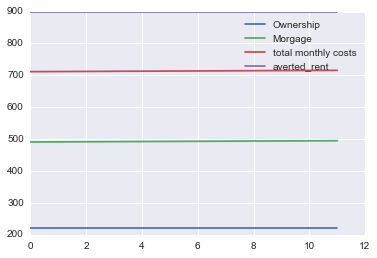

In [181]:
d = {
'home_price' : 100000.0,
'down_payment' : 0.2,
'maintenance': 0.01,
'home_owners_insurance': 0.0056,
'mortgage_term' : 15,
'mortgage_rate' : 0.037,
'property_tax' : 0.017,
'marginal_tax_rate' : 0.36,
'stock_market' : 0.06,
'house_appreciation' : 0.03,
'years'  : 1,
'income_rent'  : 900,
'personal_rent' : 900,
'rent_rate' : 0.03,
}

bottom_line(d, income = False)